# Week 2: Q-Learning - Tic-Tac-Toe
## Lecture Demonstration

**Course:** Reinforcement Learning - Continuing Education  
**Institution:** Zurich University of Applied Sciences

---

## Today's Topics
1. From Bandits to Sequential Decision Making
2. Value Functions and Q-Values
3. The Q-Learning Algorithm
4. Value-Based vs Policy-Based Methods
5. Live Demo: Training an agent to play Tic-Tac-Toe

## 1. From Bandits to MDPs

**Last week:** Multi-Armed Bandits
- Single state, multiple actions
- Immediate rewards only
- Goal: Find the best arm

**This week:** Markov Decision Processes (MDPs)
- Multiple states
- Actions cause state transitions
- Delayed rewards (actions now affect future)
- Goal: Find the best action **in each state**

### The Key Insight
In an MDP, we need to learn:
$$Q(s, a) = \text{Expected total reward from taking action } a \text{ in state } s$$

This is called the **Q-value** or **action-value function**.

## 2. Value-Based vs Policy-Based Methods

### Value-Based (Today's Focus)
- Learn the **value** of each state-action pair: $Q(s, a)$
- Derive policy by picking action with highest value: $\pi(s) = \arg\max_a Q(s, a)$
- Examples: Q-Learning, DQN, SARSA

### Policy-Based (Next Weeks)
- Learn the **policy** directly: $\pi(a|s) = P(\text{action } a | \text{state } s)$
- No need for value function
- Examples: REINFORCE, PPO, A2C

### Key Difference
| Aspect | Value-Based | Policy-Based |
|--------|-------------|-------------|
| Learns | Q(s,a) values | π(a|s) probabilities |
| Policy | Implicit (argmax) | Explicit |
| Action space | Discrete (typically) | Discrete or Continuous |
| Exploration | ε-greedy, UCB | Built into stochastic policy |

## 3. The Q-Learning Algorithm

### Core Update Rule
$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]$$

Where:
- $\alpha$ = learning rate (how fast we update)
- $\gamma$ = discount factor (how much we value future rewards)
- $r$ = immediate reward
- $s'$ = next state
- $\max_{a'} Q(s', a')$ = value of best action in next state

### Intuition
- **Target:** $r + \gamma \max_{a'} Q(s', a')$ (what we think Q should be)
- **Error:** Target - Current estimate
- **Update:** Move current estimate toward target

### Key Property: Off-Policy
Q-learning updates toward the **best** next action, even if we didn't take it. This is called **off-policy** learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from IPython.display import clear_output
import time

np.random.seed(42)
random.seed(42)

## 4. Tic-Tac-Toe Environment

Let's build a complete Tic-Tac-Toe environment to demonstrate Q-learning.

**State:** The board configuration (9 positions, each X, O, or empty)  
**Actions:** Place your mark in an empty position (0-8)  
**Reward:** +1 for win, -1 for loss, 0 for draw or ongoing

In [2]:
class TicTacToe:
    """Tic-Tac-Toe game environment."""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        """Reset the board to empty."""
        self.board = [' '] * 9  # 9 empty positions
        self.current_player = 'X'  # X always goes first
        self.done = False
        self.winner = None
        return self.get_state()
    
    def get_state(self):
        """Return board as a tuple (hashable for Q-table)."""
        return tuple(self.board)
    
    def get_valid_actions(self):
        """Return list of empty positions."""
        return [i for i in range(9) if self.board[i] == ' ']
    
    def step(self, action):
        """Make a move and return (next_state, reward, done)."""
        if self.board[action] != ' ' or self.done:
            raise ValueError(f"Invalid action: {action}")
        
        # Make the move
        self.board[action] = self.current_player
        
        # Check for winner
        if self._check_winner(self.current_player):
            self.done = True
            self.winner = self.current_player
            reward = 1 if self.current_player == 'X' else -1
            return self.get_state(), reward, True
        
        # Check for draw
        if ' ' not in self.board:
            self.done = True
            return self.get_state(), 0, True
        
        # Switch player
        self.current_player = 'O' if self.current_player == 'X' else 'X'
        return self.get_state(), 0, False
    
    def _check_winner(self, player):
        """Check if player has won."""
        wins = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6]              # Diagonals
        ]
        return any(all(self.board[i] == player for i in combo) for combo in wins)
    
    def render(self):
        """Display the board."""
        print("\n")
        for i in range(3):
            row = self.board[i*3:(i+1)*3]
            print(f" {row[0]} | {row[1]} | {row[2]} ")
            if i < 2:
                print("-----------")
        print("\n")

# Test the environment
env = TicTacToe()
env.render()
print("Valid actions:", env.get_valid_actions())



   |   |   
-----------
   |   |   
-----------
   |   |   


Valid actions: [0, 1, 2, 3, 4, 5, 6, 7, 8]


## 5. Approach 1: Random Agent (Baseline)

Before Q-learning, let's see how a random agent performs.

In [7]:
def random_agent(env):
    """Select a random valid action."""
    return random.choice(env.get_valid_actions())

def play_game(agent_x, agent_o, env, verbose=False):
    """Play a game between two agents. Returns winner ('X', 'O', or None for draw)."""
    state = env.reset()
    
    while not env.done:
        if env.current_player == 'X':
            action = agent_x(env)
        else:
            action = agent_o(env)
        
        state, reward, done = env.step(action)
        
        if verbose:
            env.render()
    
    return env.winner

# Play 1000 games: Random vs Random
env = TicTacToe()
results = {'X': 0, 'O': 0, 'Draw': 0}

for _ in range(1000):
    winner = play_game(random_agent, random_agent, env)
    if winner == 'X':
        results['X'] += 1
    elif winner == 'O':
        results['O'] += 1
    else:
        results['Draw'] += 1

print("Random vs Random (1000 games):")
print(f"  X wins:  {results['X']} ({results['X']/10:.1f}%)")
print(f"  O wins:  {results['O']} ({results['O']/10:.1f}%)")
print(f"  Draws:   {results['Draw']} ({results['Draw']/10:.1f}%)")

Random vs Random (1000 games):
  X wins:  585 (58.5%)
  O wins:  287 (28.7%)
  Draws:   128 (12.8%)


**Observation:** X wins more because X goes first. Random play leads to many wins/losses, few draws.

Optimal play in Tic-Tac-Toe always results in a draw!

## 6. Approach 2: Q-Learning Agent

Now let's implement a Q-learning agent.

In [8]:
class QLearningAgent:
    """Q-Learning agent for Tic-Tac-Toe."""
    
    def __init__(self, player, alpha=0.1, gamma=0.9, epsilon=0.1):
        """
        Args:
            player: 'X' or 'O'
            alpha: Learning rate
            gamma: Discount factor
            epsilon: Exploration rate
        """
        self.player = player
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Q-table: maps (state, action) -> value
        # Using defaultdict so unseen states default to 0
        self.Q = defaultdict(float)
    
    def get_q_value(self, state, action):
        """Get Q-value for state-action pair."""
        return self.Q[(state, action)]
    
    def get_best_action(self, state, valid_actions):
        """Return action with highest Q-value."""
        q_values = [self.get_q_value(state, a) for a in valid_actions]
        max_q = max(q_values)
        # If multiple actions have max Q, choose randomly among them
        best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
        return random.choice(best_actions)
    
    def select_action(self, env, training=True):
        """Select action using epsilon-greedy policy."""
        state = env.get_state()
        valid_actions = env.get_valid_actions()
        
        if training and random.random() < self.epsilon:
            # Explore: random action
            return random.choice(valid_actions)
        else:
            # Exploit: best action
            return self.get_best_action(state, valid_actions)
    
    def update(self, state, action, reward, next_state, next_valid_actions, done):
        """Update Q-value using Q-learning update rule."""
        current_q = self.get_q_value(state, action)
        
        if done:
            # Terminal state: no future rewards
            target = reward
        else:
            # Non-terminal: include discounted future value
            next_q_values = [self.get_q_value(next_state, a) for a in next_valid_actions]
            max_next_q = max(next_q_values) if next_q_values else 0
            target = reward + self.gamma * max_next_q
        
        # Q-learning update
        self.Q[(state, action)] = current_q + self.alpha * (target - current_q)

print("Q-Learning Agent class created!")
print("Key components:")
print("  - Q-table: stores value of each (state, action) pair")
print("  - select_action: epsilon-greedy exploration")
print("  - update: Q-learning update rule")

Q-Learning Agent class created!
Key components:
  - Q-table: stores value of each (state, action) pair
  - select_action: epsilon-greedy exploration
  - update: Q-learning update rule


## 7. Training the Q-Learning Agent

We'll train the agent by playing many games against itself (self-play).

In [9]:
def train_agent(agent, opponent_agent, n_episodes=10000, verbose_every=2000):
    """Train agent by playing against opponent."""
    env = TicTacToe()
    wins = 0
    losses = 0
    draws = 0
    
    win_history = []
    
    for episode in range(n_episodes):
        state = env.reset()
        
        # Store trajectory for learning
        trajectory = []  # [(state, action, reward), ...]
        
        while not env.done:
            if env.current_player == agent.player:
                # Agent's turn
                action = agent.select_action(env, training=True)
                old_state = state
                state, reward, done = env.step(action)
                trajectory.append((old_state, action, reward, state, done))
            else:
                # Opponent's turn
                action = opponent_agent(env)
                state, reward, done = env.step(action)
                
                # If opponent just moved and game ended, we need to update
                # our last action with the negative reward (we lost or drew)
                if done and len(trajectory) > 0:
                    s, a, r, ns, d = trajectory[-1]
                    trajectory[-1] = (s, a, -reward, state, True)  # Negate opponent's reward
        
        # Learn from trajectory
        for i, (s, a, r, ns, d) in enumerate(trajectory):
            next_valid = env.get_valid_actions() if not d else []
            agent.update(s, a, r, ns, next_valid, d)
        
        # Track results
        if env.winner == agent.player:
            wins += 1
        elif env.winner is None:
            draws += 1
        else:
            losses += 1
        
        # Track win rate over time
        if (episode + 1) % 100 == 0:
            win_history.append(wins / (episode + 1))
        
        if verbose_every and (episode + 1) % verbose_every == 0:
            print(f"Episode {episode + 1}: Wins={wins}, Losses={losses}, Draws={draws}, "
                  f"Win Rate={wins/(episode+1)*100:.1f}%")
    
    return win_history

# Create and train agent
agent_x = QLearningAgent(player='X', alpha=0.1, gamma=0.9, epsilon=0.2)

print("Training Q-Learning agent (X) against Random opponent...\n")
win_history = train_agent(agent_x, random_agent, n_episodes=10000)

print(f"\nQ-table size: {len(agent_x.Q)} state-action pairs learned")

Training Q-Learning agent (X) against Random opponent...

Episode 2000: Wins=1223, Losses=541, Draws=236, Win Rate=61.2%
Episode 4000: Wins=2455, Losses=1095, Draws=450, Win Rate=61.4%
Episode 6000: Wins=3738, Losses=1630, Draws=632, Win Rate=62.3%
Episode 8000: Wins=5043, Losses=2165, Draws=792, Win Rate=63.0%
Episode 10000: Wins=6385, Losses=2666, Draws=949, Win Rate=63.8%

Q-table size: 12790 state-action pairs learned


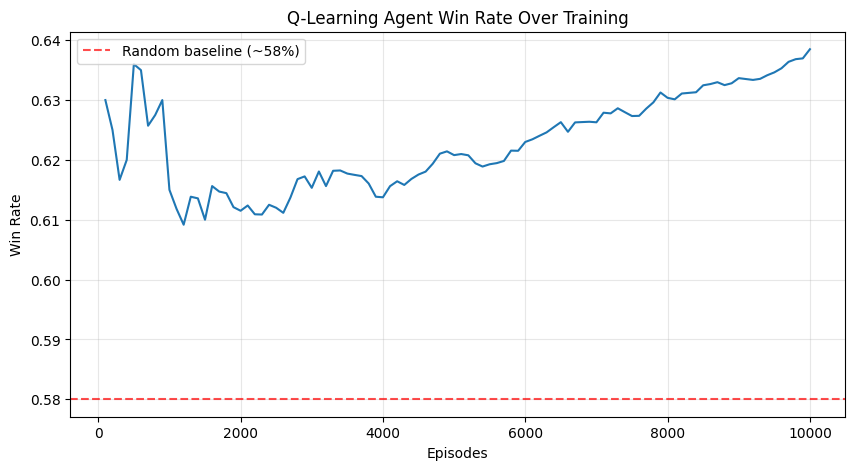

In [10]:
# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(np.arange(100, 10001, 100), win_history)
plt.xlabel('Episodes')
plt.ylabel('Win Rate')
plt.title('Q-Learning Agent Win Rate Over Training')
plt.axhline(y=0.58, color='r', linestyle='--', label='Random baseline (~58%)', alpha=0.7)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Evaluating the Trained Agent

Let's see how well our trained agent performs against random opponents.

In [14]:
def evaluate_agent(agent, opponent, n_games=1000):
    """Evaluate agent (no exploration during evaluation)."""
    env = TicTacToe()
    results = {'wins': 0, 'losses': 0, 'draws': 0}
    
    for _ in range(n_games):
        state = env.reset()
        
        while not env.done:
            if env.current_player == agent.player:
                action = agent.select_action(env, training=False)  # No exploration!
            else:
                action = opponent(env)
            state, reward, done = env.step(action)
        
        if env.winner == agent.player:
            results['wins'] += 1
        elif env.winner is None:
            results['draws'] += 1
        else:
            results['losses'] += 1
    
    return results

# Evaluate
results = evaluate_agent(agent_x, random_agent, n_games=1000)

print("Trained Q-Learning Agent vs Random (1000 games):")
print(f"  Wins:   {results['wins']} ({results['wins']/10:.1f}%)")
print(f"  Losses: {results['losses']} ({results['losses']/10:.1f}%)")
print(f"  Draws:  {results['draws']} ({results['draws']/10:.1f}%)")
print(f"\nCompare to Random vs Random: ~58% wins, ~29% losses, ~13% draws")

Trained Q-Learning Agent vs Random (1000 games):
  Wins:   691 (69.1%)
  Losses: 233 (23.3%)
  Draws:  76 (7.6%)

Compare to Random vs Random: ~58% wins, ~29% losses, ~13% draws


**Observation:** The Q-learning agent wins much more often than the random baseline!

## 9. Watching the Agent Play

Let's watch the trained agent play a game.

In [20]:
def watch_game(agent, opponent, agent_is_x=True):
    """Watch a game between agent and opponent with visualization."""
    env = TicTacToe()
    state = env.reset()
    
    print("=" * 30)
    print("Game Start!")
    print(f"Agent plays: {'X' if agent_is_x else 'O'}")
    print("=" * 30)
    env.render()
    
    move_num = 1
    while not env.done:
        if (env.current_player == 'X') == agent_is_x:
            action = agent.select_action(env, training=False)
            player_type = "Agent"
        else:
            action = opponent(env)
            player_type = "Random"
        
        print(f"Move {move_num}: {player_type} ({env.current_player}) plays position {action}")
        state, reward, done = env.step(action)
        env.render()
        move_num += 1
    
    print("=" * 30)
    if env.winner:
        print(f"Winner: {env.winner}!")
    else:
        print("It's a draw!")
    print("=" * 30)

# Watch a game
watch_game(agent_x, random_agent, agent_is_x=True)

Game Start!
Agent plays: X


   |   |   
-----------
   |   |   
-----------
   |   |   


Move 1: Agent (X) plays position 8


   |   |   
-----------
   |   |   
-----------
   |   | X 


Move 2: Random (O) plays position 3


   |   |   
-----------
 O |   |   
-----------
   |   | X 


Move 3: Agent (X) plays position 7


   |   |   
-----------
 O |   |   
-----------
   | X | X 


Move 4: Random (O) plays position 6


   |   |   
-----------
 O |   |   
-----------
 O | X | X 


Move 5: Agent (X) plays position 2


   |   | X 
-----------
 O |   |   
-----------
 O | X | X 


Move 6: Random (O) plays position 1


   | O | X 
-----------
 O |   |   
-----------
 O | X | X 


Move 7: Agent (X) plays position 5


   | O | X 
-----------
 O |   | X 
-----------
 O | X | X 


Winner: X!


## 10. Inspecting Q-Values

Let's look at what the agent learned by examining some Q-values.

In [31]:
def show_q_values(agent, env):
    """Display Q-values for current board state."""
    state = env.get_state()
    valid_actions = env.get_valid_actions()
    
    print("Current board:")
    env.render()
    
    print("Q-values for each position:")
    print("(Position: Q-value)\n")
    
    q_display = []
    for i in range(9):
        if i in valid_actions:
            q_val = agent.get_q_value(state, i)
            q_display.append(f"{q_val:+.2f}")
        else:
            q_display.append("  " + env.board[i] + "  ")
    
    for i in range(3):
        row = q_display[i*3:(i+1)*3]
        print(f" {row[0]} | {row[1]} | {row[2]} ")
        if i < 2:
            print("-------------------")
    
    best_action = agent.get_best_action(state, valid_actions)
    print(f"\nBest action: position {best_action}")

# Start a fresh game and show Q-values
env = TicTacToe()
env.reset()

print("Empty board - Q-values:")
show_q_values(agent_x, env)

Empty board - Q-values:
Current board:


   |   |   
-----------
   |   |   
-----------
   |   |   


Q-values for each position:
(Position: Q-value)

 +0.00 | +0.00 | +0.00 
-------------------
 +0.00 | +0.00 | +0.00 
-------------------
 +0.00 | +0.00 | +0.00 

Best action: position 8


In [47]:
# After some moves
env.reset()
env.step(4)  # X plays center
env.step(0)  # O plays corner

print("After X plays center, O plays corner:")
show_q_values(agent_x, env)

After X plays center, O plays corner:
Current board:


 O |   |   
-----------
   | X |   
-----------
   |   |   


Q-values for each position:
(Position: Q-value)

   O   | +0.00 | +0.00 
-------------------
 +0.00 |   X   | +0.00 
-------------------
 +0.00 | +0.00 | +0.00 

Best action: position 8


In [50]:
# A critical position - agent should block!
env.reset()
env.board = ['O', 'O', ' ', 
             ' ', 'X', ' ', 
             ' ', ' ', ' ']
env.current_player = 'X'

print("Critical position - X must block position 2!")
show_q_values(agent_x, env)

Critical position - X must block position 2!
Current board:


 O | O |   
-----------
   | X |   
-----------
   |   |   


Q-values for each position:
(Position: Q-value)

   O   |   O   | +0.00 
-------------------
 +0.00 |   X   | +0.00 
-------------------
 +0.00 | +0.00 | +0.00 

Best action: position 6


## 11. Improving Training: Self-Play

Training against a random opponent is limited. The agent can learn much better by playing against itself (self-play).

In [55]:
def train_self_play(n_episodes=20000, verbose_every=5000):
    """Train two agents by playing against each other."""
    env = TicTacToe()
    
    # Two agents that learn simultaneously
    agent_x = QLearningAgent(player='X', alpha=0.1, gamma=0.9, epsilon=0.3)
    agent_o = QLearningAgent(player='O', alpha=0.1, gamma=0.9, epsilon=0.3)
    
    results = {'X': 0, 'O': 0, 'Draw': 0}
    draw_history = []
    
    for episode in range(n_episodes):
        state = env.reset()
        
        trajectory_x = []
        trajectory_o = []
        
        while not env.done:
            if env.current_player == 'X':
                action = agent_x.select_action(env, training=True)
                old_state = state
                state, reward, done = env.step(action)
                trajectory_x.append((old_state, action, reward, state, done))
            else:
                action = agent_o.select_action(env, training=True)
                old_state = state
                state, reward, done = env.step(action)
                # O gets negative of X's reward
                trajectory_o.append((old_state, action, -reward, state, done))
        
        # Update final rewards based on who won
        if env.winner == 'X' and trajectory_o:
            s, a, r, ns, d = trajectory_o[-1]
            trajectory_o[-1] = (s, a, -1, ns, d)  # O lost
        elif env.winner == 'O' and trajectory_x:
            s, a, r, ns, d = trajectory_x[-1]
            trajectory_x[-1] = (s, a, -1, ns, d)  # X lost
        
        # Learn from trajectories
        for s, a, r, ns, d in trajectory_x:
            next_valid = [] if d else [i for i in range(9) if ns[i] == ' ']
            agent_x.update(s, a, r, ns, next_valid, d)
        
        for s, a, r, ns, d in trajectory_o:
            next_valid = [] if d else [i for i in range(9) if ns[i] == ' ']
            agent_o.update(s, a, r, ns, next_valid, d)
        
        # Track results
        if env.winner == 'X':
            results['X'] += 1
        elif env.winner == 'O':
            results['O'] += 1
        else:
            results['Draw'] += 1
        
        if (episode + 1) % 100 == 0:
            draw_history.append(results['Draw'] / (episode + 1))
        
        if verbose_every and (episode + 1) % verbose_every == 0:
            print(f"Episode {episode + 1}: X={results['X']}, O={results['O']}, "
                  f"Draws={results['Draw']} ({results['Draw']/(episode+1)*100:.1f}%)")
    
    return agent_x, agent_o, draw_history

print("Training with self-play...\n")
agent_x_sp, agent_o_sp, draw_history = train_self_play(n_episodes=20000)

Training with self-play...

Episode 5000: X=2775, O=1542, Draws=683 (13.7%)
Episode 10000: X=5256, O=3033, Draws=1711 (17.1%)
Episode 15000: X=7588, O=4363, Draws=3049 (20.3%)
Episode 20000: X=9849, O=5716, Draws=4435 (22.2%)


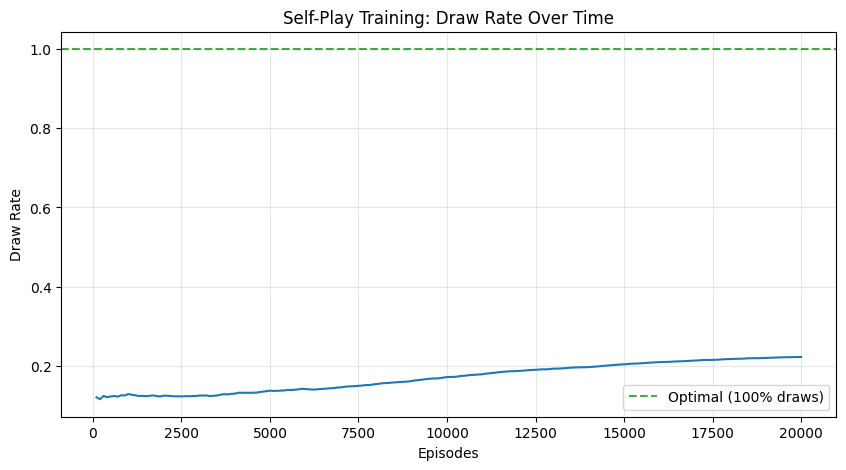


As agents improve, they draw more often (optimal play always draws in Tic-Tac-Toe)!


In [56]:
# Plot draw rate over training
plt.figure(figsize=(10, 5))
plt.plot(np.arange(100, 20001, 100), draw_history)
plt.xlabel('Episodes')
plt.ylabel('Draw Rate')
plt.title('Self-Play Training: Draw Rate Over Time')
plt.axhline(y=1.0, color='g', linestyle='--', label='Optimal (100% draws)', alpha=0.7)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nAs agents improve, they draw more often (optimal play always draws in Tic-Tac-Toe)!")

In [ ]:
# Evaluate self-play trained agent against random
results = evaluate_agent(agent_x_sp, random_agent, n_games=1000)

print("Self-Play Trained Agent vs Random (1000 games):")
print(f"  Wins:   {results['wins']} ({results['wins']/10:.1f}%)")
print(f"  Losses: {results['losses']} ({results['losses']/10:.1f}%)")
print(f"  Draws:  {results['draws']} ({results['draws']/10:.1f}%)")

## 12. Effect of Hyperparameters

Let's see how different hyperparameters affect learning.

In [58]:
def quick_train_and_eval(alpha, gamma, epsilon, n_episodes=5000):
    """Train agent and return final performance."""
    agent = QLearningAgent(player='X', alpha=alpha, gamma=gamma, epsilon=epsilon)
    env = TicTacToe()
    
    # Quick training against random
    for _ in range(n_episodes):
        state = env.reset()
        trajectory = []
        
        while not env.done:
            if env.current_player == 'X':
                action = agent.select_action(env, training=True)
                old_state = state
                state, reward, done = env.step(action)
                trajectory.append((old_state, action, reward, state, done))
            else:
                action = random_agent(env)
                state, reward, done = env.step(action)
                if done and trajectory:
                    s, a, r, ns, d = trajectory[-1]
                    trajectory[-1] = (s, a, -reward, state, True)
        
        for s, a, r, ns, d in trajectory:
            next_valid = [] if d else [i for i in range(9) if ns[i] == ' ']
            agent.update(s, a, r, ns, next_valid, d)
    
    # Evaluate
    results = evaluate_agent(agent, random_agent, n_games=500)
    return results['wins'] / 500 * 100

# Test different learning rates
print("Effect of Learning Rate (α):")
alphas = [0.01, 0.1, 0.3, 0.5]
for alpha in alphas:
    win_rate = quick_train_and_eval(alpha=alpha, gamma=0.9, epsilon=0.2)
    print(f"  α = {alpha}: {win_rate:.1f}% wins")

print("\nEffect of Discount Factor (γ):")
gammas = [0.5, 0.9, 0.99, 1.0]
for gamma in gammas:
    win_rate = quick_train_and_eval(alpha=0.1, gamma=gamma, epsilon=0.2)
    print(f"  γ = {gamma}: {win_rate:.1f}% wins")

print("\nEffect of Exploration Rate (ε):")
epsilons = [0.0, 0.1, 0.3, 0.5]
for epsilon in epsilons:
    win_rate = quick_train_and_eval(alpha=0.1, gamma=0.9, epsilon=epsilon)
    print(f"  ε = {epsilon}: {win_rate:.1f}% wins")

Effect of Learning Rate (α):
  α = 0.01: 66.6% wins
  α = 0.1: 62.8% wins
  α = 0.3: 67.4% wins
  α = 0.5: 67.6% wins

Effect of Discount Factor (γ):
  γ = 0.5: 66.6% wins
  γ = 0.9: 69.8% wins
  γ = 0.99: 68.6% wins
  γ = 1.0: 69.8% wins

Effect of Exploration Rate (ε):
  ε = 0.0: 66.8% wins
  ε = 0.1: 66.4% wins
  ε = 0.3: 71.6% wins
  ε = 0.5: 66.4% wins


## 13. Key Takeaways

### Q-Learning Summary
1. **Q-values** estimate the expected future reward for each state-action pair
2. **Update rule** moves estimates toward observed rewards + discounted future value
3. **Off-policy:** learns about optimal policy while following exploratory policy
4. **Tabular:** works for small, discrete state spaces (like Tic-Tac-Toe)

### Value-Based vs Policy-Based
- **Value-based** (Q-learning): Learn values, derive policy as argmax
- **Policy-based** (next week): Learn policy directly
- Both have advantages in different settings

### Practical Insights
- **Self-play** produces stronger agents than training against random
- **Hyperparameters matter:** α, γ, ε all affect learning
- **Exploration is crucial:** ε=0 often fails to find good strategies
- **Evaluation should disable exploration** (ε=0 during testing)

### Limitations of Tabular Q-Learning
- State space must be finite and small
- Can't generalize to unseen states
- Next step: **Deep Q-Networks (DQN)** use neural networks to approximate Q-values

---

## Next: Lab Exercise
In the lab, you'll implement Q-learning for the **Nim** game and play against your trained agent!